Group: 
- João Morais
- Vitor Santos
- Madalena Martins


# GA1

In [101]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [102]:
class YieldCurve:
    # a) Build a class called YieldCurve that will receive an array with information on maturity, 
    # price and coupon for n self.info (n x 3)
    def __init__(self, info):
        self.info = info
        self.maturity = info[:,0]
        self.price = info[:,1]
        self.coupon = info[:,2]

   #Function to get cashflows
    def get_cashflows(self):
        # Create the array that will hold the cashflows
        cf = np.zeros([len(self.info),len(self.info)])
        
        # Iterate through the bond info provided
        for index, bond in enumerate(self.info):

            maturity = bond[0]# get bond maturity

            # For every year until the coupon maturity
            for year in range(0,int(maturity)): 

                # if it is the maturity date
                if year == maturity-1:
                    cf[index, year] = 100+bond[2]
                else: # otherwise
                    cf[index, year] = bond[2]
        return cf

    # b) Add a method that will bootstrap the discount factors using matrix operations
    def get_df_with_matrix(self):

        # Get cashflows
        cf = self.get_cashflows()

        # Get discount factors by multiplying the inverse of the cashflows matrix by the bond prices
        dfs = np.linalg.inv(cf) @ self.price

        return dfs

    # C)
    def get_df_with_GS(self):
        
        #Create an array that will hold the calculated spot rates
        zeros = np.zeros((len(self.info)))

        #For each bon in the information provided
        for bond in self.info:

            maturity, price, coupon = bond # get the bond's maturity, price and coupon
            coupon /= 100 # get the correct coupon format
            maturity = int(maturity) 

            # Get cashflow
            known_cf = sum([coupon/(1+zeros[n])**(n+1) for n in range(maturity -1)]) * 100
            
            # Apply a global solver that will calculate the spot rates
            f = lambda z : known_cf + ((1 + coupon) * 100)/(1+z)**maturity - price
            zero = optimize.newton(f, 0)
            zeros[int(maturity)-1] = zero
        
        #Get the discount factors fromt he calculated spot rates
        dfs = np.array([1/(1+z)**(n+1) for n,z in enumerate(zeros)])
        return dfs
    
    # D)
    def get_df_with_bootstrap(self):

        #Get the bonds cashflows
        cf = self.get_cashflows()

        #Create an array that will hold the calculated dfs
        df=np.zeros((len(self.info)))

        #Iterate through the bond info
        for index, bond in enumerate(self.info):

            # establish the info necessary for each iteration
            summ = 0
            maturity, price, coupon = bond
            coupon /= 100
            maturity = int(maturity)

            # find the first DF
            if index ==0:
                df[index]=price/cf[0][0]
            else:
                # until the maturity, multiply the CFs by the corresponding DFs (the ones we already calculted)
                # and sum it up 
                for i in range(index):
                    summ = summ + cf[index][i]*df[i]
                # re-arrange the PV equation to find the missing DF, calculate it and add it to the
                # DF array
                df[index]=(price-summ)/cf[index][index]

        return df


### a) Build a class called YieldCurve that will receive an array with information on maturity, price and coupon for n bonds (n x 3)

In [103]:
bonds = np.array([[1, 96.6, 1.5], 
                        [2, 93.71, 1.75],
                        [3, 91.56, 2],
                        [4, 90.24, 2.25],
                        [5, 89.74, 2.5],
                        [6, 90.04, 2.75], 
                        [7, 91.09, 3],
                        [8, 92.82, 3.25],
                        [9, 95.19, 3.50],
                        [10, 98.14, 3.75]])
yc = YieldCurve(bonds)

### b) Add a method that will bootstrap the discount factors using matrix operations

In [104]:
yc.get_df_with_matrix()

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

### c) Add a method that will bootstrap the discount factors using a global solver

In [105]:
yc.get_df_with_GS()

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

### d) Add a method that will bootstrap the discount factors using an iterative procedure

In [106]:
dfs = yc.get_df_with_bootstrap()
dfs

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

### e) Determine the spot rate (annual compounding) for each maturity from the calculated discount factors and plot them 

In [107]:
# Ryear: this are the rates for each year
# Price = C/(1+R1)^1 + C/(1+R2)^2 + ... + (FV+C)/(1+Rn)^maturity

#Calculate the spot rates using the previously calculated discount factors
spot_rate = [pow(1/d, 1/(m+1))-1 for m,d in enumerate(dfs)]
spot_rate

[0.050724637681159424,
 0.051400860610055776,
 0.051051216278840794,
 0.0499871990315186,
 0.048495786203275326,
 0.046703613833167346,
 0.04473810744647344,
 0.042716980245643965,
 0.040675087218742245,
 0.03867431347507222]

In [108]:
#Asset if the spot rates were correctly calculated by verifying if:
                #[CF]*[DFS]==PV
cfs = yc.get_cashflows()
np.testing.assert_allclose((cfs @ dfs) ,yc.price,rtol=1e-8, atol=0)

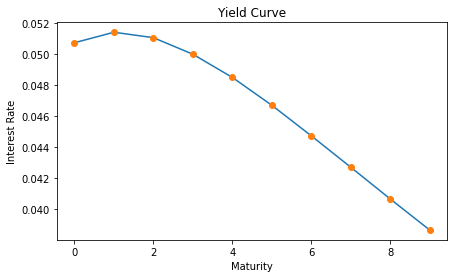

In [109]:
# Plot them
x = np.linspace(0, cfs.shape[1], cfs.shape[1], endpoint = False)
plt.figure(figsize=(7, 4))
plt.plot(x, spot_rate)
plt.plot(x, spot_rate, 'o')

#Establish figure characteristics 
plt.xlabel('Maturity')
plt.ylabel('Interest Rate')
plt.title('Yield Curve')
plt.show()

### f) Determine the YTM for each bond and plot them

In [110]:
# YTM: this is like a weigthed average of the previous spot rates. So the price of the bond is the same if
# we calculate it with the different spot rates of each year or with only the YTM for every year
# Price = C/(1+R1)^1 + C/(1+R2)^2 + ... + (FV+C)/(1+Rn)^maturity 
#       = C/(1+YTM)^1 + C/(1+YTM)^2 + ... + (FV+C)/(1+YTM)^maturity
#  This has to be done using a solver or optimization to find the value of YTM corresponding to each price
import scipy.optimize as optimize
import matplotlib.pyplot as plt

#Create array to 
ytms = np.zeros(len(yc.info))

#Iterate through each bond in the info provided
for idx, bond in enumerate(yc.info):

    # set the variables necessary
    maturity, price, coupon = bond
    coupon /= 100
    maturity = int(maturity)

    # find the YTM that satisfies each bond's information
    ytm_func = lambda y : sum([(coupon if n < int(maturity) else coupon + 1)/(1+y)**n
                               for n in range(1, int(maturity) +1)]) * 100 - price
    ytms[idx] =(optimize.newton(ytm_func, 0))
    
ytms


array([0.05072464, 0.0513948 , 0.05105361, 0.05002602, 0.04860682,
       0.04693075, 0.04512745, 0.04331056, 0.04151381, 0.03979082])

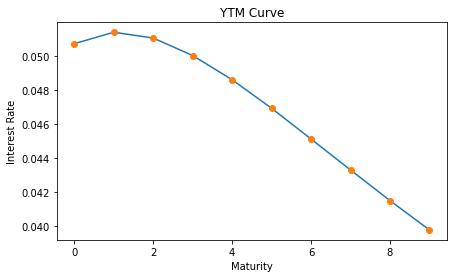

In [111]:
# Plot 
plt.figure(figsize=(7, 4))
plt.plot(x, ytms)
plt.plot(x, ytms, 'o')

#Establish figure characteristics 
plt.xlabel('Maturity')
plt.ylabel('Interest Rate')
plt.title('YTM Curve')
plt.show()

### g) Determine the 1y forward rate starting in each of the years from 1 to 9 and plot them

In [112]:
#Array to keep forward rates
f = np.zeros(len(yc.info))

#Iterate through each bond in the info provided
for index, bond in enumerate(yc.info):

    if index == 0: # if it is the 1 year bond starting at year zero...
        f[index] = spot_rate[index] # ...the forward rate is equal to the spot rate
    else:
        # else we just apply the forward rate formula
        f[index]=( (1+ spot_rate[index])**index / (1+spot_rate[index-1])**(index-1) ) - 1
f

array([0.05072464, 0.05140086, 0.05070169, 0.04786239, 0.04403425,
       0.03956551, 0.0349658 , 0.03067206, 0.02649336, 0.02280598])

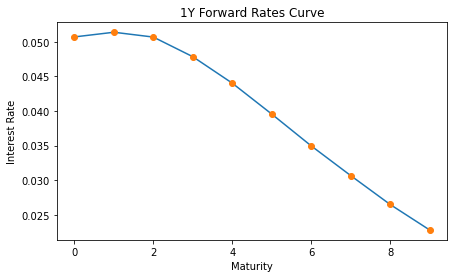

In [113]:
# Plot 
plt.figure(figsize=(7, 4))
plt.plot(x, f)
plt.plot(x, f, 'o')

#Establish figure characteristics 
plt.xlabel('Maturity')
plt.ylabel('Interest Rate')
plt.title('1Y Forward Rates Curve')
plt.show()

# GA2

In [114]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import date

### a) Get historical data (close price and volume) for 5 stocks of your choice using any API of your choice from 2012 to the present time

In [115]:
#define the ticker symbol
tickers = ['GOOG','MNST','MSFT','V','F']

tickerDict = {}
for ticker in tickers:
    #get data on this ticker
    df = pd.DataFrame(yf.Ticker(ticker).history(period='1d', start='2012-01-01', end=date.today()))

    #adds the key(ticker)->value(ticker volume and close data) to the tickerDict
    tickerDict[ticker] = df[['Volume','Close']]

### b) Plot the cumulative returns of the stocks on a single chart

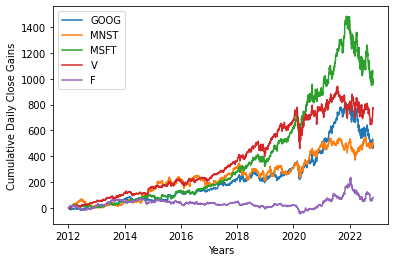

In [116]:
# For each key(ticker)...
for (key,value) in tickerDict.items():
    # ... get the 'Close' values cumulative gains
    plt.plot(((1+value['Close'].pct_change()).cumprod() -1 ) *100)

plt.legend(tickerDict.keys())  
plt.xlabel('Years')
plt.ylabel('Cumulative Daily Close Gains')  
plt.show()

### c) Create the correlation matrix of the daily returns

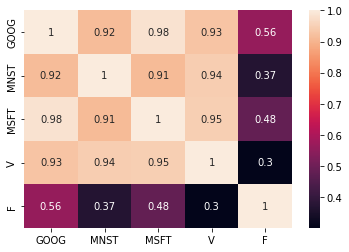

In [117]:
corr_matrix = pd.DataFrame(columns = tickerDict.keys())

for (key,value) in tickerDict.items():
    # ... get the 'Close' values cumulative gains and add them to the corr_matrix DataFrame
    corr_matrix[key]=((1+value['Close'].pct_change()).cumprod() -1 ) *100
# Plot the heat map of the correlation
sn.heatmap(corr_matrix.corr(), annot=True)
plt.show()

### d) Save the data (close price and volume) to a CSV file for each ticker

In [118]:
header = ["Close", "Volume"]
for (key,value) in tickerDict.items():
    value.to_csv(key+'.csv', columns = header)

### e) Load the data from the CSV files you saved into a single DataFrame with the prices for each ticker

In [119]:
#List to save the different company dataframe
li = []

#Loop through the company anems
for key in tickerDict.keys():

    df = pd.read_csv(key+'.csv',  header=0) # for each company, open the csv file and read the info
    df['Ticker']=key # add a company name to the column with the values
    li.append(df[['Date','Close','Ticker']]) #save the dataframe in the list

#Concat all the previously saved dfs
frame = pd.concat(li, axis=0, ignore_index=True)

#Organize the dataframe to the wanted shape
frame = frame.pivot(index ='Date', columns = 'Ticker', values = 'Close')
print(frame)

Ticker              F        GOOG       MNST        MSFT           V
Date                                                                
2012-01-03   7.345916   16.573130  15.416667   21.527195   23.878485
2012-01-04   7.458116   16.644611  15.431667   22.033813   23.451881
2012-01-05   7.649520   16.413727  15.643333   22.258976   23.628086
2012-01-06   7.728723   16.189817  15.896667   22.604767   23.349861
2012-01-09   7.788123   15.503389  15.986667   22.307234   23.162064
...               ...         ...        ...         ...         ...
2022-10-25  12.830000  104.930000  91.660004  250.660004  194.380005
2022-10-26  12.820000   94.820000  92.010002  231.320007  203.330002
2022-10-27  13.000000   92.599998  91.730003  226.750000  204.289993
2022-10-28  13.260000   96.580002  93.540001  235.869995  209.339996
2022-10-31  13.370000   94.660004  93.720001  232.130005  207.160004

[2726 rows x 5 columns]
